In [21]:
# Libraries
using Random
using LinearAlgebra
using StatsBase
using Plots
using ExponentialUtilities
using LaTeXStrings
using Printf


# Create data set
True model: $y=f(z)=\sin(z)$ for $z\in[-\pi,\pi]$.

Data: $N=10$ equidistant measurements $y$ plus random Gaussian noise.

In [22]:
# Create data set

# number of samples
N = 10

# input values, randomly distributed in 
# the interval [-pi, pi]
z = range(-pi,pi, length=N)

# output values
y = sin.(z) + 0.3 * randn(N);

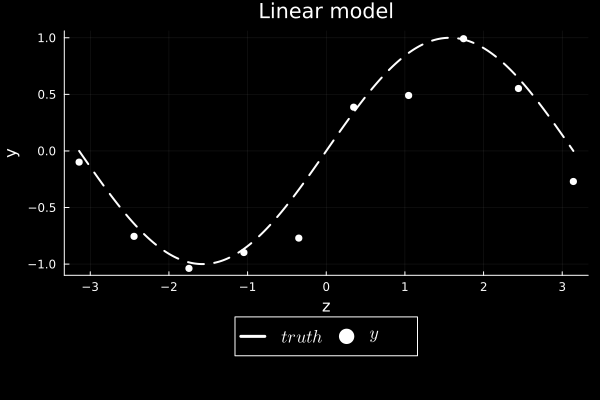

In [23]:
# Plotting the results

# array for creating analytical plot lines
N_grid = 1000
z_grid = range(-pi,pi, length=N_grid)
y_grid = sin.(z_grid)

# plot
p1 = plot(xlabel="z", ylabel="y",
     title="Linear model",grid=true,
     background_color="#000000")
plot!(p1, z_grid, y_grid, linecolor=:white, linestyle=:dash,
     linewidth=2, label=L"truth")
scatter!(p1, z, y, mc=:white, linestyle=:solid,
     linewidth=2, label=L"y")
plot!(p1, legend=:outerbottom, legendcolumns=2, legendfontcolor=:white,
     legendfontsize=12)

# Comparison against the closed-form solution

Now let's train a polynomial model of degree $q-1$:
$$ h(z,w) = w_0 + w_1 z + \ldots + w_{q-1} z^{q-1}. $$
To this end, we use the mean squared error as our loss function:
$$L(w) = \frac{1}{N}\sum_{i=1}^N \|y_i - h(z_i,w)\|_2^2 $$

Creating the data matrices
$$ Z = \begin{bmatrix} 1 & z_1 & z_1^2 & \ldots & z_1^{q-1} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & z_N & z_N^2 & \ldots & z_N^{q-1} \end{bmatrix} \quad \text{and} \quad Y = \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix} $$
and using the mean squared loss $\|Y-Zw\|_F^2$, we find the closed-form solution
$$w = Z^\dag Y.$$

In [24]:
# data matrix
function createZ(z, q);
    N = length(z)

    # build a polynomial of order q
    Z = zeros(N, q);

    # data matrix
    for i in 1 : q
        Z[:, i] = z.^(i-1);
    end
    return Z
end;

# Train the model
function train_model(Z, y)
    N, q = size(Z)

    # pseudo inverse
    w = pinv(Z) * y;

    return w
end

# model evaluation
function h(z, w)
    N = length(z)
    q = length(w)
    
    y = zeros(N)
    for n in 1 : N
        for i in 1 : q
            y[n] += w[i] * z[n]^(i-1)
        end
    end
    return y
end;

In [25]:
# let's use a polynomial of degree 3
q = 4

# create data matrix
Z = createZ(z, q);

# train model using least squares regression
w_pinv = train_model(Z, y)

# evaluate model on the fine grid
y_pinv = h(z_grid, w_pinv);

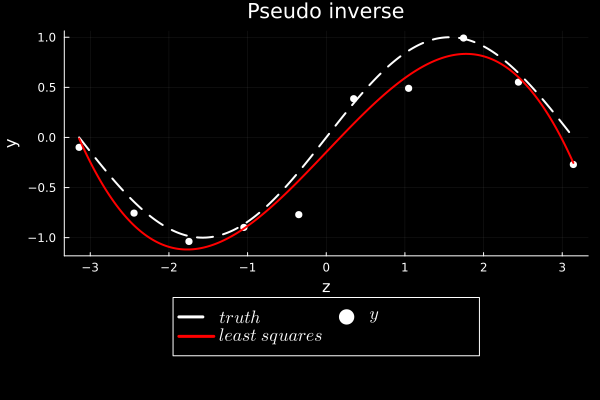

In [26]:
# Plotting the results
p1 = plot(xlabel="z", ylabel="y",
title="Pseudo inverse",grid=true,
background_color="#000000")
plot!(p1, z_grid, y_grid, linecolor=:white, linestyle=:dash,
    linewidth=2, label=L"truth")
scatter!(p1, z, y, mc=:white, linestyle=:solid,
    linewidth=2, label=L"y")
plot!(p1, z_grid, y_pinv, linecolor=:red, linestyle=:solid,
    linewidth=2, label=L"least~squares")
plot!(p1, legend=:outerbottom, legendcolumns=2, 
    legendfontcolor=:white, legendfontsize=12)

# Gradient descent with steepest descend direction and fixed step sizes

Now let's use gradient descent on the loss function $L(w)$.

The gradient of an individual sample $\ell$ w.r.t. a single coefficient $w_j$ is:
$$ \frac{\partial \ell(w)}{\partial w_j} = -2 (y_i - h(z_i, w)) z^j, $$
where $z^j$ is located in column $j+1$ of the data matrix $Z$. (Entry $i$ for sample $i$.)

The entire gradient is thus
$$ \nabla L(w) = -\frac{2}{N} Z^\top (y - Zw). $$

In [27]:
# Loss function
function L(w, Z, y)
    N = length(y)
    return 1/N * norm(y - Z * w, 2)^2
end;

# gradient of loss function
function dL(w, Z, y)
    N = length(y)
    return 2/N * Z' * (Z * w - y)
end;

In [28]:
# initial guess w0
w0 = zeros(q)

# learning rate / step size
eta = 0.001

# iterative scheme
i_max = 1000
w_all = zeros(q, i_max)
L_all = zeros(i_max)

w_all[:, 1] = w0
L_all[1] = L(w0, Z, y)

for i in 1:i_max - 1
    # gradient step
    w_all[:, i + 1] = w_all[:, i] - eta * dL(w_all[:, i], Z, y)

    # store loss function value
    L_all[i + 1] = L(w_all[:, i + 1], Z, y)
end

# optimal value
w_star = w_all[:, i_max]

# evaluate final model
y_gd = h(z_grid, w_star);

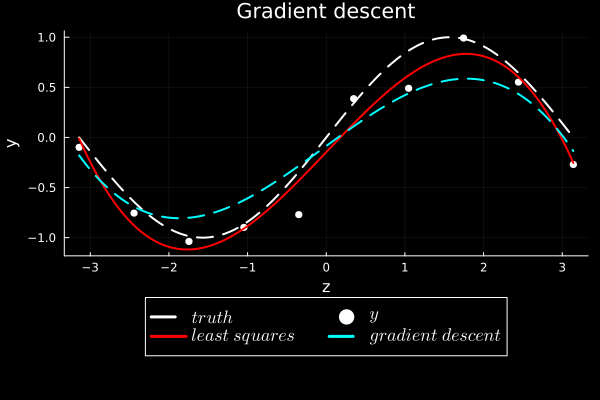

In [29]:
# Plotting the results
p1 = plot(xlabel="z", ylabel="y",
title="Gradient descent",grid=true,
background_color="#000000")
plot!(p1, z_grid, y_grid, linecolor=:white, linestyle=:dash,
    linewidth=2, label=L"truth")
scatter!(p1, z, y, mc=:white, linestyle=:solid,
    linewidth=2, label=L"y")
plot!(p1, z_grid, y_pinv, linecolor=:red, linestyle=:solid,
    linewidth=2, label=L"least~squares")
plot!(p1, z_grid, y_gd, linecolor=:cyan, linestyle=:dash,
    linewidth=2, label=L"gradient~descent")
plot!(p1, legend=:outerbottom, legendcolumns=2, legendfontcolor=:white,
    legendfontsize=12)

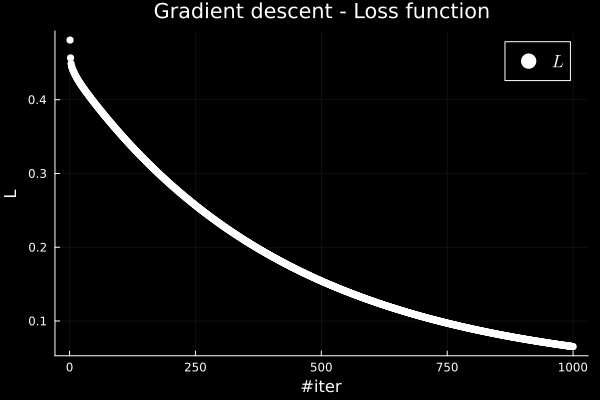

In [30]:
# Loss function iterates
p1 = plot(xlabel="#iter", ylabel="L",
title="Gradient descent - Loss function",grid=true,
background_color="#000000")
scatter!(p1, range(1,i_max,i_max), L_all, mc=:white, label=L"L")
plot!(p1, legendfontcolor=:white, legendfontsize=12)

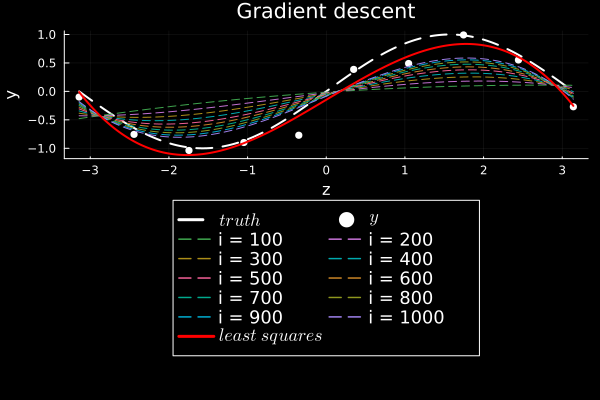

In [31]:
# model iterates

# Plotting the results
p1 = plot(xlabel="z", ylabel="y",
title="Gradient descent",grid=true,
background_color="#000000")
plot!(p1, z_grid, y_grid, linecolor=:white, linestyle=:dash,
    linewidth=2, label=L"truth")
scatter!(p1, z, y, mc=:white, linestyle=:solid,
    linewidth=2, label=L"y")
for i in 100:100:i_max
    y_i = h(z_grid, w_all[:,i]);
    plot!(p1, z_grid, y_i, linestyle=:dash,
        linewidth=1, label=@sprintf("i = %.d",i))
end
plot!(p1, z_grid, y_pinv, linecolor=:red, linestyle=:solid,
    linewidth=2, label=L"least~squares")
plot!(p1, legend=:outerbottom, legendcolumns=2, legendfontcolor=:white,
    legendfontsize=12)

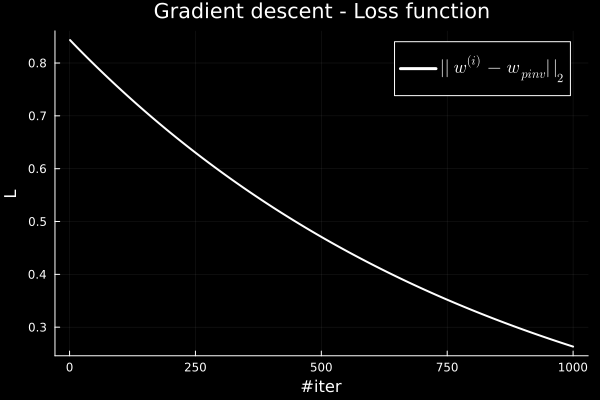

In [32]:
# Weight iterates
delta_w = zeros(i_max)
for i in 1:i_max
    delta_w[i] = norm(w_all[:,i] - w_pinv, 2)
end

p1 = plot(xlabel="#iter", ylabel="L",
title="Gradient descent - Loss function",grid=true,
background_color="#000000")
plot!(p1, range(1,i_max,i_max), delta_w, lc=:white, 
    lw=2, label=L"||w^{(i)} - w_{pinv} ||_2")
plot!(p1, legendfontcolor=:white, legendfontsize=12)


Now let's try some additional stopping criteria, i.e.,
$$ \nabla L(w) < \epsilon_\nabla \qquad \text{or} \qquad L^{(i)} - L^{(i+1)} < \epsilon_L$$

In [33]:
# let's try once more using different stopping criteria

# threshholds for the gradient as well as the loss function improvement
eps_grad = 1e-5
eps_L = 1e-5

# initial guess
w_SC = w0

# dummy variable to compare with previous iteration
L_prev = 1e10

# for loop over (too) many iterations
for i in 1:1000000
    
    # compute gradient ...
    dL_i = dL(w_SC, Z, y)

    # ... and check whether it is small
    if norm(dL_i, 2) < eps_grad
        @printf("Stopping after %d iterations: ||dL|| = %0.4e", 
            i, norm(dL_i, 2))
        break
    end

    # if not, update weights
    w_SC = w_SC - eta * dL_i

    # compute updated loss function
    L_i = L(w_SC, Z, y)

    # check for sufficient decrease of L
    if L_prev - L_i < eps_L
        @printf("Stopping after %d iterations: ||L_{i-1} - L_i|| = %0.4e", 
            i, L_prev - L_i)
        break
    end

end

@printf("\nDifference to pinv: ||w_pinv - w_SC|| = %0.4e", 
            norm(w_pinv - w_SC, 2))

Stopping after 11035 iterations: ||dL|| = 9.9925e-06
Difference to pinv: ||w_pinv - w_SC|| = 1.1530e-05

Let's compare the performance of different learning rates

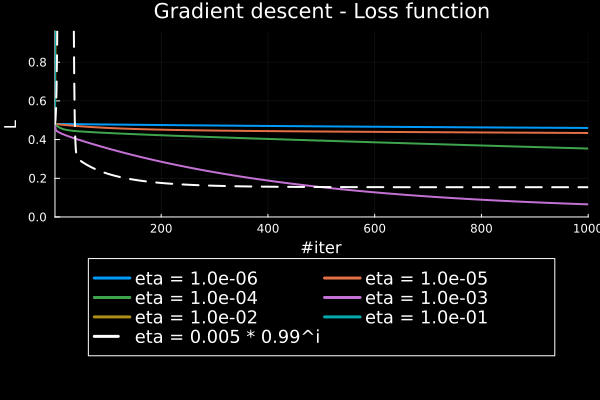

In [34]:
# compare different learning rates
# initial guess w0
w0 = zeros(q)

# learning rate / step size
eta_all = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1];

# set up empty plot
p1 = plot(xlabel="#iter", ylabel="L",
    title="Gradient descent - Loss function",grid=true,
    background_color="#000000", xlims=(1,1000),
    ylims=(0,2*L(w0, Z, y)))

# train for all eta in eta_all
for eta in eta_all
    
    w_eta = w0
    L_eta = zeros(1000)
    L_eta[1] = L(w_eta, Z, y)
    for i in 1:999
        # gradient step
        w_eta = w_eta - eta * dL(w_eta, Z, y)

        # store loss function value
        L_eta[i + 1] = L(w_eta, Z, y)
    end

    # Add plot to scatter
    plot!(p1, range(1,1000,1000), L_eta, 
        lw=2, label=@sprintf("eta = %0.1e", eta))
end

# Finally, an adaptive step size
w_eta = w0
L_eta = zeros(1000)
L_eta[1] = L(w_eta, Z, y)

eta = 5e-3
for i in 1:999
    # gradient step
    w_eta = w_eta - eta * dL(w_eta, Z, y)

    eta *= 0.99

    # store loss function value
    L_eta[i + 1] = L(w_eta, Z, y)
end

# Add plot to scatter
plot!(p1, range(1,1000,1000), L_eta, lc=:white, ls=:dash,
    lw=2, label="eta = 0.005 * 0.99^i")
    
plot!(p1, legend=:outerbottom, legendcolumns=2, 
    legendfontcolor=:white, legendfontsize=12)

# Armijo backtracking

Starting with a step length $\eta_0$, we decrease the step size repeatedly (by multiplication with $\alpha\in(0,1)$) until a sufficient decrease is guaranteed, i.e.,
$$ L\left(w^{(i)}-\alpha^k \eta_0 \nabla L(w^{(i)})\right) \leq L(w^{(i)}) - \epsilon_{1} \left(\nabla L(w^{(i)})\right)^\top \nabla L(w^{(i)}).$$

In [35]:
# compare different learning rates, same as last time

# initial guess w0
w0 = zeros(q)

# learning rate / step size
eta_all = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1];

# set up empty plot
p1 = plot(xlabel="#iter", ylabel="L",
    title="Gradient descent - Loss function",grid=true,
    background_color="#000000", xlims=(1,1000),
    ylims=(0,2*L(w0, Z, y)))

# train for all eta in eta_all
for eta in eta_all
    
    w_eta = w0
    L_eta = zeros(1000)
    L_eta[1] = L(w_eta, Z, y)
    for i in 1:999
        # gradient step
        w_eta = w_eta - eta * dL(w_eta, Z, y)

        # store loss function value
        L_eta[i + 1] = L(w_eta, Z, y)
    end

    # Add plot to scatter
    plot!(p1, range(1,1000,1000), L_eta, 
        lw=2, label=@sprintf("eta = %0.1e", eta))
end

1000

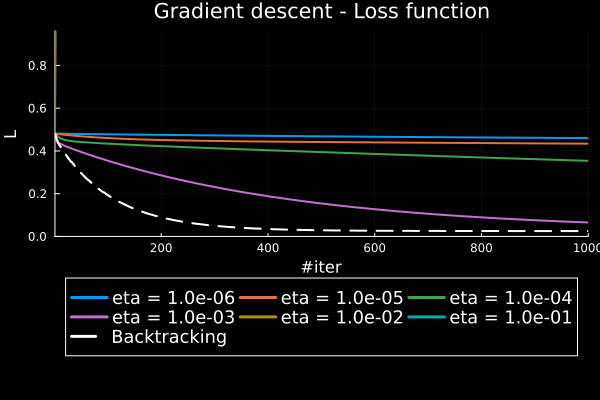

In [36]:
# And here comes the Armijo code
w_eta = w0
L_eta = zeros(1000)
L_eta[1] = L(w_eta, Z, y)

eta_all = zeros(1000)

eta0 = 1e-2
alpha = 0.9

eps_1 = 1e-4
eps_grad = 1e-6

iMax = 1000
for i in 1:999
    # evaluate gradient
    dL_i = dL(w_eta, Z, y)

    # stopping criterion for small gradient
    if norm(dL_i, 2) < eps_grad
        @printf("Stopping after %d iterations: ||dL|| = %0.4e", 
            i, norm(dL_i, 2))
        iMax = i
        break
    end

    # backtracking loop
    eta = eta0
    while L(w_eta - eta * dL_i, Z, y) > L_eta[i] - eps_1 * eta * dot(dL_i, dL_i)
        eta *= alpha

        # stop if step length gets too small
        if eta < 1e-6
            iMax = i
            break
        end
    end

    # stop the entire routine if the step length is too small
    # and set the last index with a meaningful output
    if eta < 1e-6
        iMax = i
        break
    end

    # gradient step
    w_eta = w_eta - eta * dL_i

    # store current eta value
    eta_all[i] = eta

    # store loss function value
    L_eta[i + 1] = L(w_eta, Z, y)
end

print(iMax)

# Add plot to scatter
plot!(p1, range(1,iMax,iMax), L_eta[1:iMax], lc=:white, ls=:dash,
    lw=2, label="Backtracking")
    
plot!(p1, legend=:outerbottom, legendcolumns=3, 
    legendfontcolor=:white, legendfontsize=12)

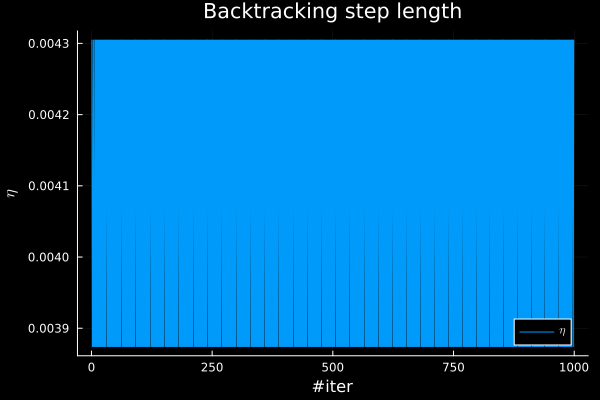

In [37]:
# visualize the step length
p1 = plot(xlabel="#iter", ylabel=L"\eta",
    title="Backtracking step length",grid=true,
    background_color="#000000")
plot!(p1, eta_all[1:iMax-1],label=L"\eta")

# Stochastic gradient descend

To reduce the cost of a particular gradient evluation, we can compute the gradient using only a subset of the samples $\{z_i,y_i\}$

In [38]:
# Stochastic loss function and gradient
function stochastic_L(w, Z, y, s=1)
    N = length(y)
    indices = sample(1:N, s, replace = false)

    L = 1/s * norm(y[indices] - Z[indices, :] * w, 2)^2
    dL = 2/s * Z[indices, :]' * (Z[indices, :] * w - y[indices])

    return L, dL
end;

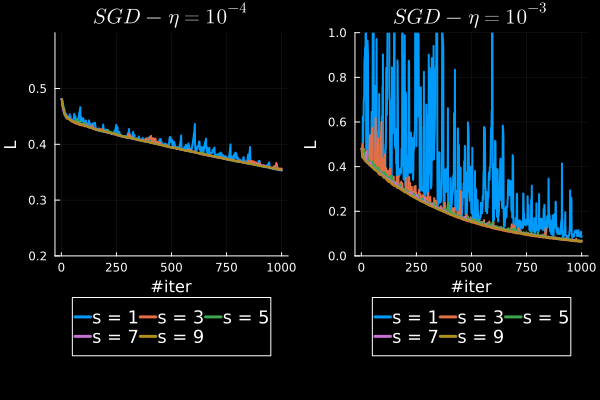

In [41]:
# compare different learning rates
# initial guess w0
q = 4
w0 = zeros(q)

# set up empty plot
p1 = plot(xlabel="#iter", ylabel="L",
    title=L"SGD - \eta=10^{-4}",grid=true,
    background_color="#000000", ylims=(0.2,.6))

p2 = plot(xlabel="#iter", ylabel="L",
    title=L"SGD - \eta=10^{-3}",grid=true,
    background_color="#000000", ylims=(0,1))

# batch size
s_all = [1,3,5,7,9]

# learning rate / step size
eta_all = [1e-4, 1e-3]

# train for all eta in eta_all
for eta in eta_all
    for s in s_all
        
        w_SGD = zeros(q, 1000)
        w_SGD[:, 1] = w0
        L_SGD = zeros(1000)
        L_SGD[1] = L(w0, Z, y)
        for i in 1:999

            # evaluate loss function and stochastic
            L_i, dL_i = stochastic_L(w_SGD[:, i], Z, y, s)

            # gradient step
            w_SGD[:, i + 1] = w_SGD[:, i] - eta * dL_i

            # store loss function value
            L_SGD[i + 1] = L(w_SGD[:, i], Z, y)
            
        end

        # Add plot to scatter
        if eta == 1e-4
            plot!(p1, range(1,1000,1000), L_SGD, 
                lw=2, label=@sprintf("s = %d", s))
        else
            plot!(p2, range(1,1000,1000), L_SGD, 
                lw=2, label=@sprintf("s = %d", s))
        end

    end
end
    
plot!(p1, legend=:outerbottom, legendcolumns=3, 
    legendfontcolor=:white, legendfontsize=12)
plot!(p2, legend=:outerbottom, legendcolumns=3, 
    legendfontcolor=:white, legendfontsize=12)

plot(p1, p2, layout=(1,2))

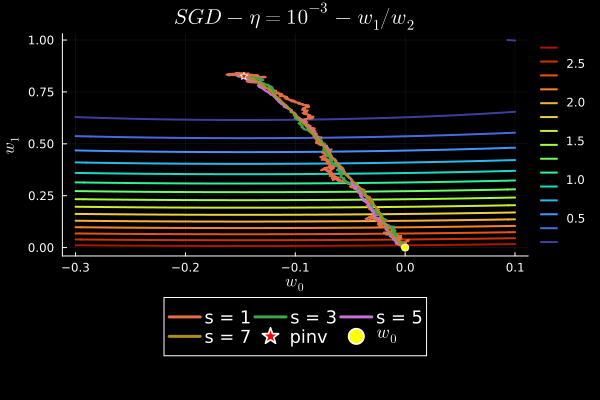

In [40]:
# Plot

# For comparison, let's create a grid of w values to show level sets of L(w)
w_grid1, w_grid2 =  range(-.3,.1, length=1000), range(-.01,1., length=1000);
L_grid = zeros(1000,1000);
for i in 1 : 1000
    for j in 1 : 1000
        L_grid[i,j] = L([w_grid1[j], w_grid2[i], w_pinv[3], w_pinv[4]], Z, y)
    end
end

# compare different learning rates
# initial guess w0
q = 4
w0 = zeros(q)

# set up empty plot
p1 = plot(xlabel=L"w_0", ylabel=L"w_1",
    title=L"SGD - \eta=10^{-3} - w_1 / w_2",grid=true,
    background_color="#000000")
contour!(p1, w_grid1, w_grid2, L_grid, color=:turbo,lw=2)

# batch size
s_all = [1,3,5,7]

# learning rate / step size
eta_all = [1e-3]

# train for all eta in eta_all
for eta in eta_all
    for s in s_all
        
        w_SGD = zeros(q, 10000)
        w_SGD[:, 1] = w0
        L_SGD = zeros(10000)
        L_SGD[1] = L(w0, Z, y)
        for i in 1:9999

            # evaluate loss function and stochastic
            L_i, dL_i = stochastic_L(w_SGD[:, i], Z, y, s)

            # gradient step
            w_SGD[:, i + 1] = w_SGD[:, i] - eta * dL_i

            # store loss function value
            L_SGD[i + 1] = L(w_SGD[:, i], Z, y)
            
        end

        # Add plot to scatter
        plot!(p1, w_SGD[1,:], w_SGD[2,:], lw=2,
            label=@sprintf("s = %d", s))
        
    end
end


scatter!(p1, [w_pinv[1]], [w_pinv[2]], 
    mc=:red, shape=:star5, label="pinv")
scatter!(p1, [w0[1]], [w0[2]], 
    mc=:yellow, label=L"w_0")
    
plot!(p1, legend=:outerbottom, legendcolumns=3, 
    legendfontcolor=:white, legendfontsize=12)